* V3 : 0.4457
* v4 : 0.4457 with nb
* v5 : 0.3725 lgb basic only
* v6 : 0.35033 lgb 1500 itr + 0.01 lr
* v7 : 0.34 lgb 300 itr + 0.002 lr

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
TARGET = 'IsUnderRisk'

## READING

In [3]:
train = pd.read_csv('./Train.csv')
test = pd.read_csv('./Test.csv')
sample = pd.read_excel('./Sample_Submission.xlsx')

In [4]:
df = train.append(test)
len(df) , len(train) , len(test)

(776, 543, 233)

In [5]:
from pandas_profiling import ProfileReport


## EDA

In [6]:
train.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [7]:
train.IsUnderRisk.sum()/len(train.IsUnderRisk)

0.6261510128913443

In [8]:
test.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results
0,41,18.272,13,12,9,7,0
1,17,64.799,6,10,7,4,1
2,31,68.890,3,3,7,8,0
3,3,16.492,15,10,7,4,1
4,9,17.178,7,3,8,3,1


In [9]:
profile = ProfileReport(train, title="Pandas Profiling Report")


In [10]:
# profile

## PREPROCESS
* None as of now

In [11]:
# OHE

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import OneHotEncoder 
  
# creating one hot encoder object with categorical feature 0 
# indicating the first column 
# onehotencoder = OneHotEncoder(categorical_features = [0])
# data = onehotencoder.fit_transform(data).toarray() 

for col in df.columns :
    if col != TARGET and col == 'City':
            dums = pd.get_dummies(df[col])
            df = df.drop([col] , axis = 1)
            df = pd.concat([df , dums] , axis = 1)

# df[-50:]

In [13]:
usingDf = 1

if usingDf == True :
    test = df[df[TARGET].isna()]
    train = df[~df[TARGET].isna()]

# test

In [14]:
len(train)

543

## TRAIN TEST SPLIT

In [15]:
# sample
TARGET = 'IsUnderRisk'
validation = 0
from sklearn.model_selection import train_test_split
# train_test_split(train , test, test_size=0.3, random_state=42)

X = train.drop([TARGET] , axis = 1)
y = train[TARGET]



# train_y.value_counts()

if validation == True : 
    train_X , test_X , train_y , test_y = train_test_split(X, y, test_size=0.3, random_state=42)
else :
    train_X = X
    train_y = y
    test_X = test.drop([TARGET] , axis = 1)
#     test_X = test.drop()

## MODEL CREATION

In [16]:
sample

,0,1
0,0.005016,0.994984
1,0.612204,0.387796
2,0.844945,0.155055
3,0.004671,0.995329
4,0.175931,0.824069
...,...,...
228,0.853997,0.146003
229,0.525997,0.474003
230,0.041434,0.958566
231,0.007320,0.992680


In [17]:
def giveRes(model , test_X ,proba) :
    if proba == 0 :
        rf_preds = model.predict(test_X)
    else :
        rf_preds = model.predict_proba(test_X)[: ,1]
    return rf_preds

In [18]:
def resultWithValidation(model ,X , y, test_X , proba):
    train_X , val_X , train_y , val_y = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(train_X, train_y,
                 eval_set=(val_X, val_y),
                 #cat_features=categorical_features_indices,
                 use_best_model=True)
    if proba == 0 :
        rf_preds = model.predict(test_X)
    else :
        rf_preds = model.predict_proba(test_X)[: ,1]
    return rf_preds


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
rf.fit(train_X , train_y)

NameError: name 'train_X' is not defined

In [33]:
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
catb =  CatBoostClassifier(iterations=10000,
                             learning_rate=0.0005,
                             depth=4,
                             eval_metric='Logloss',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             task_type = "GPU",
                             devices='0:4',
                             
                             od_wait=100)
# def result_with_validaton(model ,X , y, test_X , absolute):


In [34]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(train_X, train_y)

In [35]:
# import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

In [42]:
y3 = giveRes(reg , test_X , 0)
y2 = giveRes(gnb , test_X , 0)

In [ ]:
y0 = giveRes(rf , test_X ,proba = 1)

In [38]:
y1 = resultWithValidation(catb ,train_X , train_y, test_X , 1)

0:	learn: 0.6925987	test: 0.6924814	best: 0.6924814 (0)	total: 45.6ms	remaining: 7m 36s
50:	learn: 0.6668541	test: 0.6621279	best: 0.6621279 (50)	total: 2.41s	remaining: 7m 49s
100:	learn: 0.6429855	test: 0.6340211	best: 0.6340211 (100)	total: 4.72s	remaining: 7m 42s
150:	learn: 0.6207844	test: 0.6077843	best: 0.6077843 (150)	total: 7.1s	remaining: 7m 42s
200:	learn: 0.6004091	test: 0.5839603	best: 0.5839603 (200)	total: 9.53s	remaining: 7m 44s
250:	learn: 0.5816042	test: 0.5619959	best: 0.5619959 (250)	total: 11.8s	remaining: 7m 39s
300:	learn: 0.5641297	test: 0.5415795	best: 0.5415795 (300)	total: 14.1s	remaining: 7m 35s
350:	learn: 0.5484432	test: 0.5236989	best: 0.5236989 (350)	total: 16.4s	remaining: 7m 30s
400:	learn: 0.5335897	test: 0.5067942	best: 0.5067942 (400)	total: 18.8s	remaining: 7m 29s
450:	learn: 0.5196993	test: 0.4908620	best: 0.4908620 (450)	total: 21.1s	remaining: 7m 27s
500:	learn: 0.5069657	test: 0.4764962	best: 0.4764962 (500)	total: 23.6s	remaining: 7m 27s
550:	

4450:	learn: 0.2807214	test: 0.2518886	best: 0.2518886 (4450)	total: 3m 37s	remaining: 4m 30s
4500:	learn: 0.2800426	test: 0.2514242	best: 0.2514242 (4500)	total: 3m 40s	remaining: 4m 28s
4550:	learn: 0.2793722	test: 0.2509351	best: 0.2509351 (4550)	total: 3m 43s	remaining: 4m 28s
4600:	learn: 0.2787051	test: 0.2504231	best: 0.2504231 (4600)	total: 3m 46s	remaining: 4m 26s
4650:	learn: 0.2780400	test: 0.2499889	best: 0.2499889 (4650)	total: 3m 49s	remaining: 4m 23s
4700:	learn: 0.2773557	test: 0.2494686	best: 0.2494686 (4700)	total: 3m 52s	remaining: 4m 21s
4750:	learn: 0.2766832	test: 0.2489712	best: 0.2489712 (4750)	total: 3m 55s	remaining: 4m 19s
4800:	learn: 0.2760503	test: 0.2485132	best: 0.2485132 (4800)	total: 3m 57s	remaining: 4m 17s
4850:	learn: 0.2754359	test: 0.2480354	best: 0.2480354 (4850)	total: 4m	remaining: 4m 14s
4900:	learn: 0.2747590	test: 0.2475585	best: 0.2475585 (4900)	total: 4m 2s	remaining: 4m 12s
4950:	learn: 0.2741286	test: 0.2471636	best: 0.2471636 (4950)	tot

8850:	learn: 0.2426633	test: 0.2277073	best: 0.2277073 (8850)	total: 7m 18s	remaining: 56.9s
8900:	learn: 0.2424166	test: 0.2275707	best: 0.2275707 (8900)	total: 7m 20s	remaining: 54.4s
8950:	learn: 0.2421598	test: 0.2274449	best: 0.2274446 (8949)	total: 7m 23s	remaining: 51.9s
9000:	learn: 0.2418750	test: 0.2273051	best: 0.2273051 (9000)	total: 7m 25s	remaining: 49.5s
9050:	learn: 0.2416231	test: 0.2271602	best: 0.2271602 (9050)	total: 7m 27s	remaining: 47s
9100:	learn: 0.2413378	test: 0.2270505	best: 0.2270505 (9100)	total: 7m 30s	remaining: 44.5s
9150:	learn: 0.2410910	test: 0.2269345	best: 0.2269345 (9150)	total: 7m 32s	remaining: 42s
9200:	learn: 0.2407994	test: 0.2267883	best: 0.2267883 (9200)	total: 7m 34s	remaining: 39.5s
9250:	learn: 0.2405440	test: 0.2266623	best: 0.2266582 (9248)	total: 7m 37s	remaining: 37s
9300:	learn: 0.2402828	test: 0.2265091	best: 0.2265091 (9300)	total: 7m 39s	remaining: 34.5s
9350:	learn: 0.2400124	test: 0.2263784	best: 0.2263777 (9349)	total: 7m 41s	

## Feature importances

In [61]:
importance = catb.feature_importances_
lst = {}
cols = df.columns
for i in range(len(importance)):
    lst[cols[i]] = importance[i]
# lst

Feature: 0, Score: 7.32046
Feature: 1, Score: 44.82151
Feature: 2, Score: 18.86866
Feature: 3, Score: 16.93117
Feature: 4, Score: 0.66263
Feature: 5, Score: 0.05747
Feature: 6, Score: 0.08632
Feature: 7, Score: 0.24740
Feature: 8, Score: 0.04146
Feature: 9, Score: 0.00834
Feature: 10, Score: 0.08133
Feature: 11, Score: 0.10553
Feature: 12, Score: 1.84471
Feature: 13, Score: 0.00015
Feature: 14, Score: 0.00839
Feature: 15, Score: 0.06041
Feature: 16, Score: 0.72844
Feature: 17, Score: 0.08817
Feature: 18, Score: 0.03698
Feature: 19, Score: 0.00759
Feature: 20, Score: 0.00462
Feature: 21, Score: 0.00648
Feature: 22, Score: 0.03595
Feature: 23, Score: 0.35074
Feature: 24, Score: 0.00513
Feature: 25, Score: 0.16638
Feature: 26, Score: 0.00496
Feature: 27, Score: 0.00516
Feature: 28, Score: 0.02681
Feature: 29, Score: 0.28010
Feature: 30, Score: 0.00581
Feature: 31, Score: 0.01349
Feature: 32, Score: 0.01105
Feature: 33, Score: 0.00388
Feature: 34, Score: 0.00541
Feature: 35, Score: 0.01733

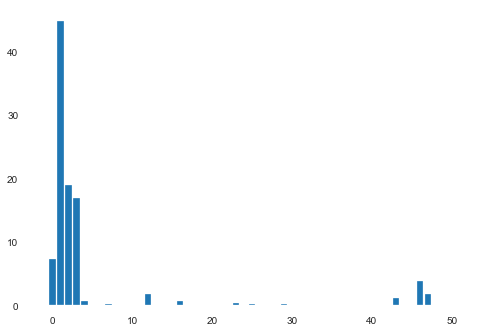

In [66]:
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# catb.get_feature_importance(data=None,
#                        type='PredictionDiff',
#                        prettified=False,
#                        thread_count=-1,
#                        verbose=False)

In [26]:
# y0

In [27]:
# y2 

In [28]:
# rf_preds = catb.predict(test_X)

In [2]:
res = (y0*3 + y1*3)/6
# res = rf_preds
# res = y1

NameError: name 'y0' is not defined

## GENERATING RESULTS

In [68]:
# y0 , y1 , y2 , y3

In [69]:
sample[0] = 1 - res
sample[1] = res
# sample[TARGET] = res
sample.to_excel('./Submit.xlsx')

In [62]:
sample

,0,1
0,0.257108,0.742892
1,0.514850,0.485150
2,0.953645,0.046355
3,0.230275,0.769725
4,0.541790,0.458210
...,...,...
228,0.835514,0.164486
229,0.520545,0.479455
230,0.655983,0.344017
231,0.219060,0.780940


In [32]:
sm1 = sample
absolute = 1
from sklearn.metrics import log_loss

# pd.set_option('display.max_rows', 500)
if absolute == 1 :
    rf_preds = model.predict(test_X)
else :
    rf_preds = model.predict_proba(test_X)[: ,1]
    
if validation == 1 :
    print(log_loss(val_y, rf_preds))
else :
    sm1[TARGET] = rf_preds
    sm1.to_excel('./Submit1.xlsx')

NameError: name 'model' is not defined

In [ ]:
rf_preds

In [ ]:
# log_loss( , rf_preds )
# for c in sample.columns:
#     sm1[c] = rf_preds[: ,c]
# sm1[]    
